In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [4]:
images_path = 'data/images'
annotations_file = 'data/images/_annotations.txt'
classes_file = 'data/images/_classes.txt'

In [5]:
# Load class labels
with open(classes_file, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

In [6]:
def parse_annotation_line(line):
    parts = line.strip().split()
    image_name = parts[0]
    annotations = []
    
    for item in parts[1:]:
        x1, y1, x2, y2, class_id = map(int, item.split(','))
        annotations.append({
            'image': image_name,
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'class_id': class_id,
            'class_name': class_names[class_id] if class_id < len(class_names) else 'unknown'
        })
        
    return annotations

In [7]:
# Parse all lines
all_annotations = []
with open(annotations_file, 'r') as f:
    for line in f:
        parsed = parse_annotation_line(line)
        all_annotations.extend(parsed)

df = pd.DataFrame(all_annotations)
df.head()

image   x1   y1   x2   y2  \
0  9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385...  247  384  294  440   
1  9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385...  172  365  223  424   
2  9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385...  314  523  380  617   
3  9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385...   89  270  129  320   
4  9999945_00000_d_0000165_jpg.rf.b66333ba0c8a385...   48  225   84  274   

   class_id class_name  
0         3        car  
1         3        car  
2         3        car  
3         3        car  
4         3        car

In [8]:
df['class_id'].unique()

array([ 3, 11,  4,  7, 10,  8,  5,  2,  6,  0,  9,  1])

In [9]:
df.shape

(471190, 7)

In [10]:
df['image'].nunique()

8626

In [11]:
def show_image_with_boxes(image_id):
    img_path = os.path.join(images_path, image_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    annots = df[df['image'] == image_id]

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    for _, row in annots.iterrows():
        rect = Rectangle((row['x1'], row['y1']),
                         row['x2'] - row['x1'],
                         row['y2'] - row['y1'],
                         linewidth=2,
                         edgecolor='red',
                         facecolor='none')
        ax.add_patch(rect)
        plt.text(row['x1'], row['y1'] - 5, row['class_name'], color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.title(image_id)
    plt.show()

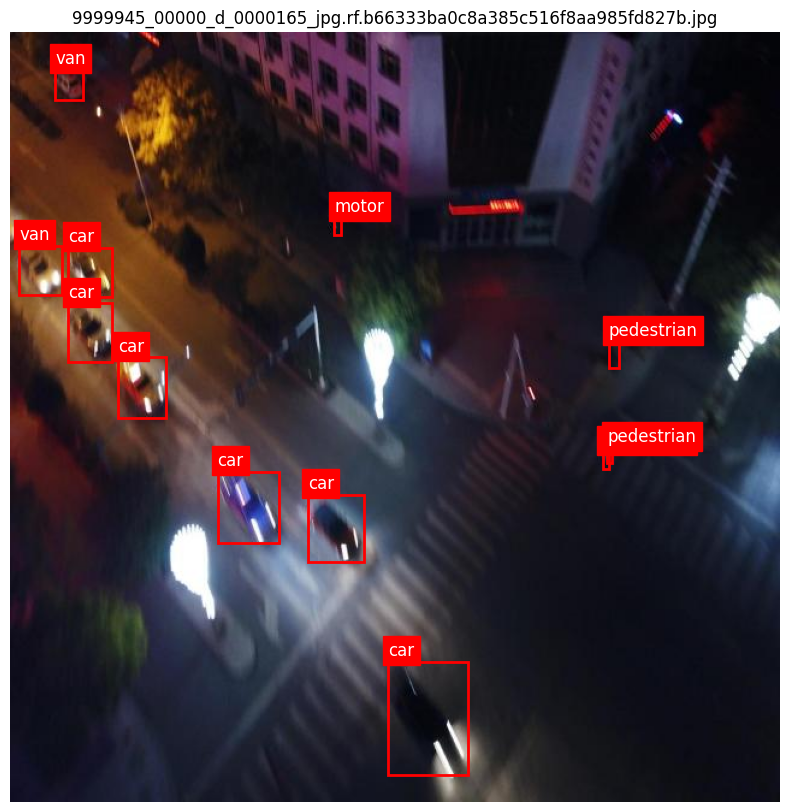

In [12]:
sample_image = df['image'].iloc[0]
show_image_with_boxes(sample_image)

In [13]:
labels_dir = os.path.join('labels')
os.makedirs(labels_dir, exist_ok=True)

img_width, img_height = 640, 640 

for image_name, group in df.groupby('image'):
    label_lines = []
    for _, row in group.iterrows():

        xc = (row.x1 + row.x2) / 2.0
        yc = (row.y1 + row.y2) / 2.0
        w  = (row.x2 - row.x1)
        h  = (row.y2 - row.y1)

        xc_norm = xc / img_width
        yc_norm = yc / img_height
        w_norm  = w  / img_width
        h_norm  = h  / img_height

        label_lines.append(f"{row.class_id} {xc_norm:.6f} {yc_norm:.6f} {w_norm:.6f} {h_norm:.6f}")
    
    label_path = os.path.join(labels_dir, os.path.splitext(image_name)[0] + '.txt')
    with open(label_path, 'w') as f:
        f.write('\n'.join(label_lines))


In [14]:
import cv2

In [15]:
cfg_path       = "yolo3\yolov3.cfg"
weights_path   = "yolo3\yolov3.weights"
classes_path   = "yolo3\coco_classes.txt" 

In [16]:
with open(classes_path, 'r') as f:
    yolo_classes = [c.strip() for c in f.readlines()]


In [17]:
net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

layer_names = net.getLayerNames()
outs = net.getUnconnectedOutLayers()
if isinstance(outs, int):
    outs = [outs]
else:
    outs = outs.flatten().tolist()

output_layers = [layer_names[i - 1] for i in outs]


In [18]:
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

In [19]:
with open(classes_path, 'r') as f:
    visdrone_classes = [c.strip() for c in f.readlines()]

In [20]:
def run_yolo_visdrone(image_path, conf_threshold=0.5, nms_threshold=0.4):
    img = cv2.imread(image_path)
    H, W = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416,416), swapRB=True, crop=False)
    
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)
    
    boxes, confidences, class_ids = [], [], []
    for output in layer_outputs:
        for det in output:
            scores = det[5:]
            cid = np.argmax(scores)
            conf = float(scores[cid])
            if conf > conf_threshold:
                cx, cy, w, h = (det[0:4] * np.array([W, H, W, H])).astype("int")
                x = int(cx - w/2)
                y = int(cy - h/2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(conf)
                class_ids.append(cid)
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    return img, boxes, confidences, class_ids, idxs

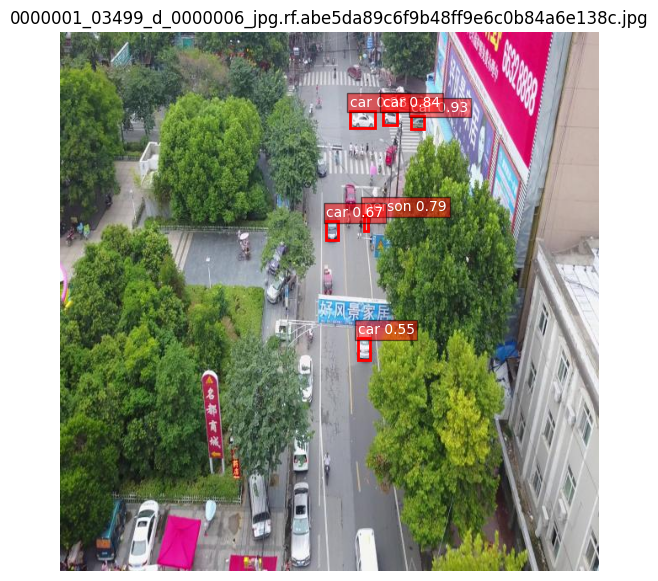

In [22]:
sample_img = os.path.join(images_path, os.listdir(images_path)[1])
img, boxes, confs, cids, idxs = run_yolo_visdrone(sample_img)

plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax = plt.gca()

if len(idxs) > 0:
    for i in idxs.flatten():
        x,y,w,h = boxes[i]
        cls = visdrone_classes[cids[i]]
        conf = confs[i]
        rect = plt.Rectangle((x,y), w, h, fill=False, linewidth=2, color='red')
        ax.add_patch(rect)
        ax.text(x, y-5, f"{cls} {conf:.2f}", color='white',
                bbox=dict(facecolor='red', alpha=0.5, pad=2))

plt.axis('off')
plt.title(os.path.basename(sample_img))
plt.show()

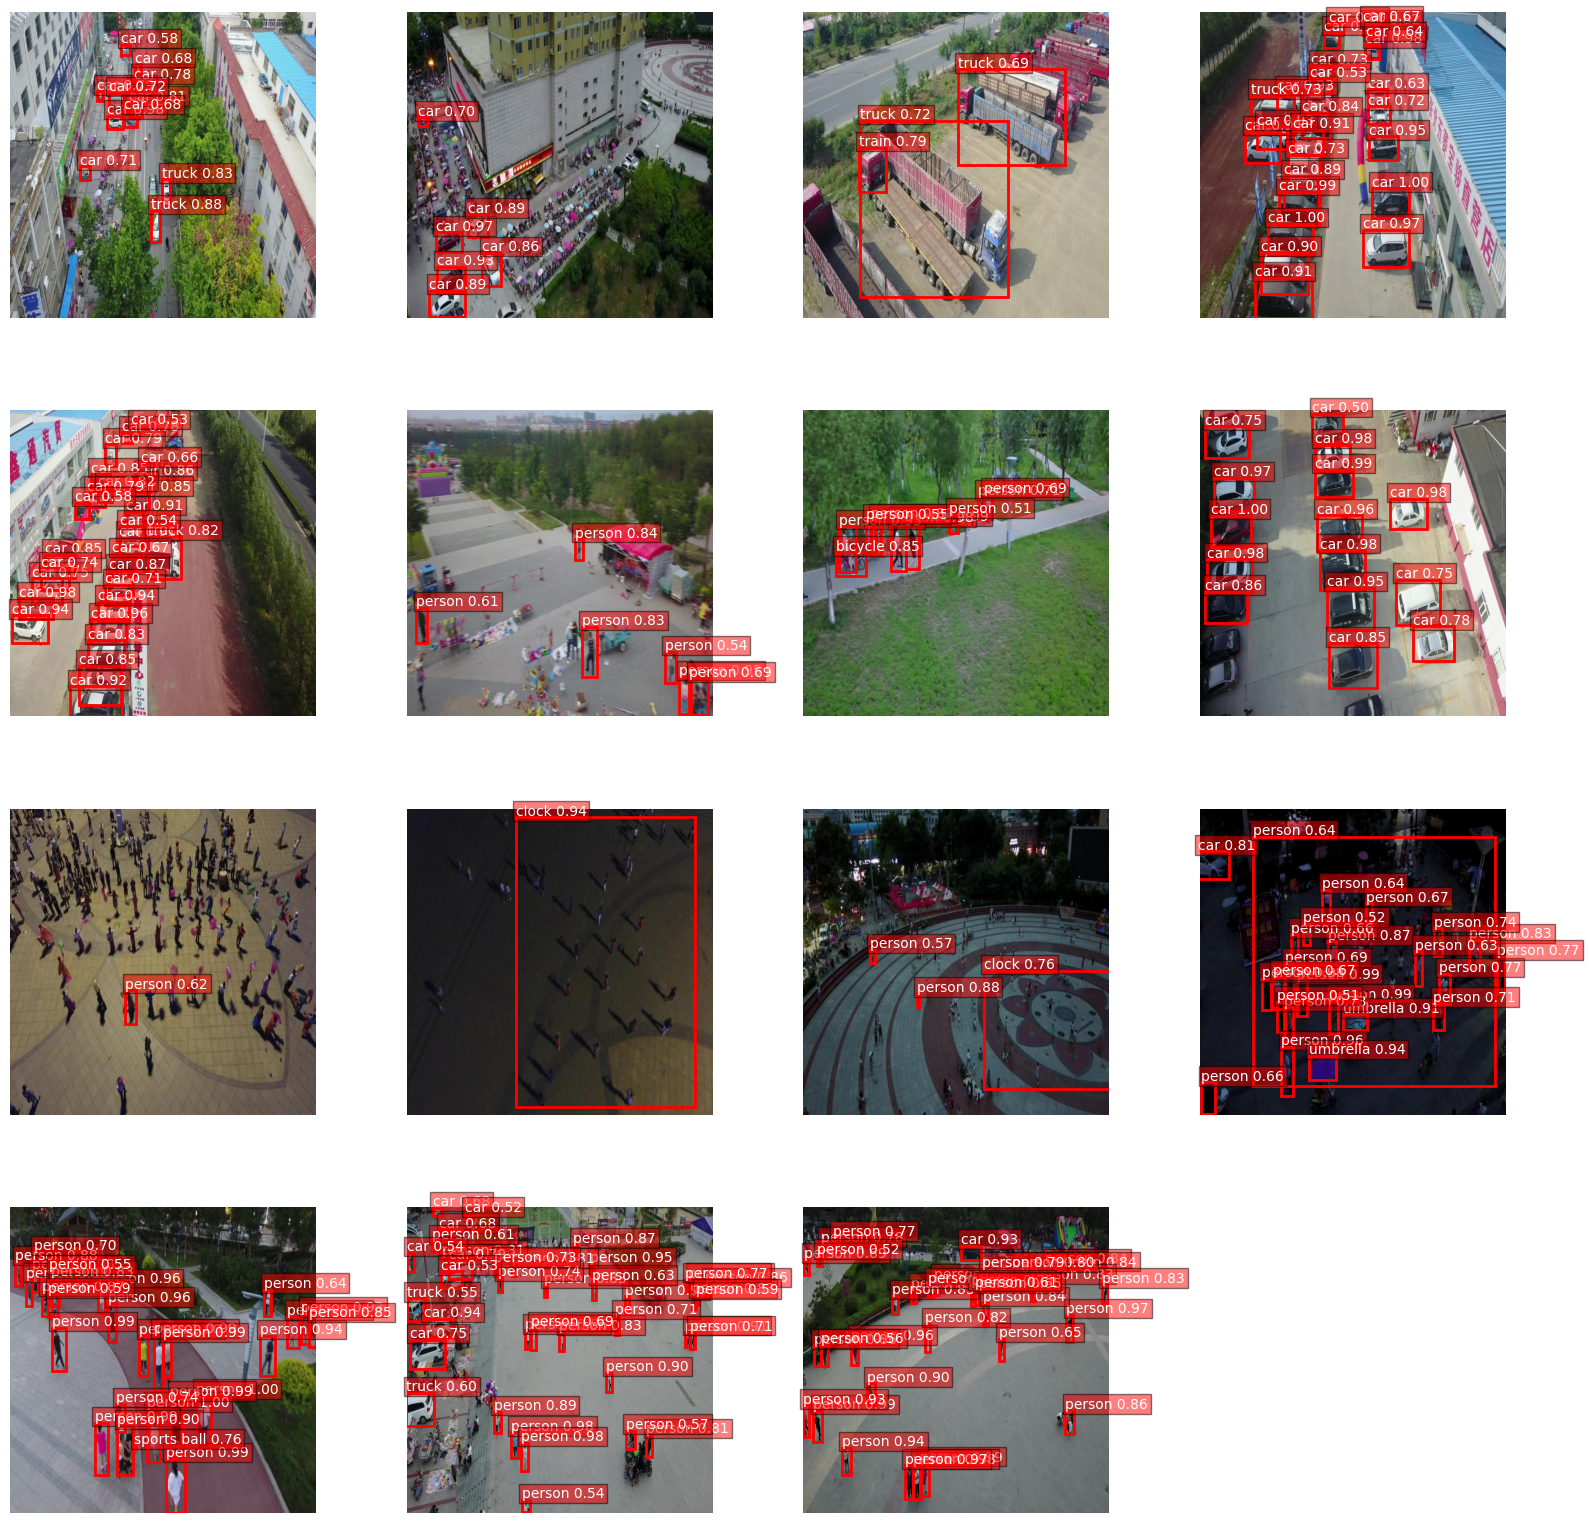

In [31]:
import matplotlib.pyplot as plt
import cv2
import os

image_files = os.listdir(images_path)
image_files = image_files[::10][:15]  
plt.figure(figsize=(16, 16))

for idx, img_file in enumerate(image_files):
    img_path = os.path.join(images_path, img_file)
    img, boxes, confs, cids, idxs = run_yolo_visdrone(img_path)

    plt.subplot(4, 4, idx + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax = plt.gca()

    if len(idxs) > 0:
        for i in idxs.flatten():
            x, y, w, h = boxes[i]
            cls = visdrone_classes[cids[i]]
            conf = confs[i]
            rect = plt.Rectangle((x, y), w, h, fill=False, linewidth=2, color='red')
            ax.add_patch(rect)
            ax.text(x, y - 5, f"{cls} {conf:.2f}", color='white',
                    bbox=dict(facecolor='red', alpha=0.5, pad=2))

    plt.axis('off')
    # Removed plt.title to hide image names

plt.tight_layout()
plt.show()


In [28]:
import tensorflow as tf
import os

images_dir = 'data/images'
labels_dir = 'data/labels'

def parse_example(image_path):
    image_name = tf.strings.split(image_path, os.sep)[-1]
    label_path = tf.strings.join([labels_dir, '/', tf.strings.regex_replace(image_name, '.jpg', '.txt')])
    
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    
    # Load label
    label_content = tf.io.read_file(label_path)
    label_lines = tf.strings.split(label_content, '\n')
    label_line = label_lines[0]  # For simplicity, take first object
    
    fields = tf.strings.to_number(tf.strings.split(label_line), out_type=tf.float32)
    class_id = tf.cast(fields[0], tf.int32)
    bbox = fields[1:]  # [x_center, y_center, width, height]
    
    return image, (bbox, class_id)

# Prepare dataset
image_paths = tf.data.Dataset.list_files(images_dir + '/*.jpg')
dataset = image_paths.map(parse_example).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# Paths
images_dir = 'data/images'
labels_dir = 'data/labels'

# Load Data
image_paths = []
labels = []

for filename in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, filename), 'r') as f:
        first_label = int(f.readline().split()[0])  # Only first class
    image_name = filename.replace('.txt', '.jpg')  # or .png
    image_paths.append(os.path.join(images_dir, image_name))
    labels.append(first_label)

# Dataset Preparation
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(AUTOTUNE)

# CNN Model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(set(labels)), activation='softmax')  # output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(dataset, epochs=10)


Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.4068 - loss: 228.0036
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.5048 - loss: 1.5316
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.6431 - loss: 1.0795
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 266s 980ms/step - accuracy: 0.8076 - loss: 0.6004
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.9284 - loss: 0.2608
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9628 - loss: 0.1464
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9741 - loss: 0.1025
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.9750 - loss: 0.1432
Epoch 9/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9713 - loss: 0.1278
Epoch 10/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9815 - loss: 0.0749


In [8]:
model.save('model.h5')

In [18]:
model.save('my_model.keras')

In [17]:
import matplotlib.pyplot as plt

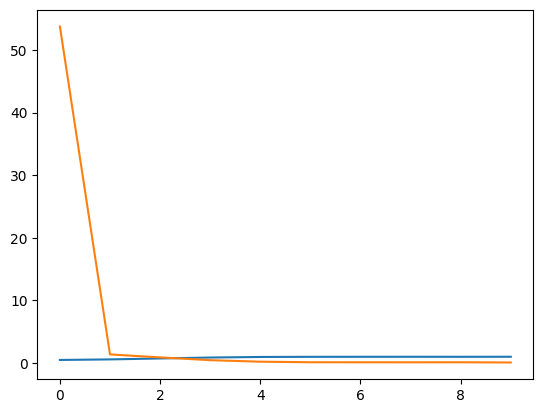

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['loss'])

In [20]:
from tensorflow.keras.models import load_model

model = load_model('my_model.keras')

In [ ]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    return image

In [29]:
df['class_name'].unique()

array(['pedestrian', 'people', 'motor', 'car', 'awning-tricycle',
       'object', 'van', 'bicycle', 'truck', 'bus', 'others', 'tricycle'],
      dtype=object)

In [32]:
import tensorflow as tf
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('my_model.keras')

# Class labels (update this according to your dataset)
class_names = ['pedestrian', 'people', 'motor', 'car', 'awning-tricycle',
       'object', 'van', 'bicycle', 'truck', 'bus', 'others', 'tricycle']  

def predict_image(image_path):
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Same size as training
    image = image / 255.0  # Normalization if applied during training
    image = tf.expand_dims(image, axis=0)  # Batch dimension

    # Predict
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    print(f"Predicted Class: {class_names[predicted_class]} ({confidence:.2f} confidence)")
    return class_names[predicted_class], confidence


In [33]:
predict_image("data\\images\\0000001_02999_d_0000005_jpg.rf.7d2167b51ad201771c58205f7686c4e6.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: car (0.49 confidence)


('car', np.float32(0.4856956))